# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [1]:
import tensorflow as tf
from tqdm import tqdm

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape, y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

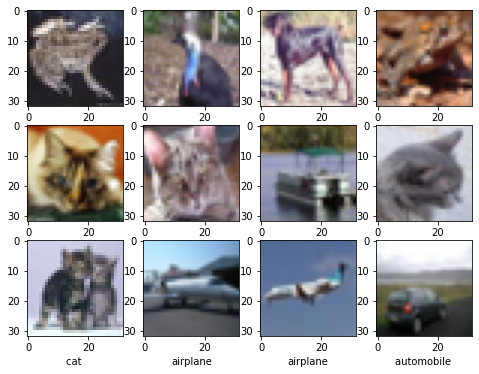

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[8,6])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [5]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [6]:
import keras
from keras import layers as L
from keras import backend as K

In [8]:
inputs = keras.Input(shape=(32, 32, 3))
print(inputs.shape)

(None, 32, 32, 3)


In [10]:
x = L.Dense(32)(inputs) ### объявление слоя
x = L.Flatten()(x)
x = L.Dropout(0.5)(x)
x = L.Activation('relu')(x)
outputs = L.Dense(10)(x)

In [11]:
model = keras.Model(inputs=inputs, outputs=outputs, name="our_first_model")
model.summary()

Model: "our_first_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
dense (Dense)                (None, 32, 32, 32)        128       
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
activation (Activation)      (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                327690    
Total params: 327,818
Trainable params: 327,818
Non-trainable params: 0
_____________________________________________

## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [15]:
%load_ext tensorboard
import datetime, os

In [16]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [49]:
%tensorboard --reuse_port False --logdir logs/fit

In [18]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), ### ОТЛИЧИЕ_ОТ_CategoricalCrossEntropy
    optimizer=tf.keras.optimizers.SGD(),
    metrics=["accuracy"],
)

# history = model.fit(X_train, y_train, batch_size=64, epochs=2, validation_split=0.2)
history = model.fit(x=X_train, 
                    y=y_train, 
                    batch_size=64, 
                    epochs=2, 
                    validation_data=(X_val, y_val), 
                    callbacks=[tensorboard_callback])

test_scores = model.evaluate(X_val, y_val, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/2
625/625 [==============================] - 44s 69ms/step - loss: 1.7079 - accuracy: 0.4034 - val_loss: 1.5852 - val_accuracy: 0.4519
Epoch 2/2
625/625 [==============================] - 42s 67ms/step - loss: 1.5419 - accuracy: 0.4660 - val_loss: 1.5466 - val_accuracy: 0.4610
313/313 - 2s - loss: 1.5466 - accuracy: 0.4610
Test loss: 1.5465689897537231
Test accuracy: 0.460999995470047


In [19]:
# !pip install tensorflow.tensorboard
# !pip show tensorflow.tensorboard

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [24]:
predict_x = model.predict(X_test) 
classes_x = np.argmax(predict_x, axis=1)

In [26]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.4587
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               256100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 257,390
Trainable params: 257,390
Non-trainable params: 0
_________________________________________________________________


In [30]:
y_train_labels = tf.keras.utils.to_categorical(y_train)

In [32]:
model.fit(X_train, 
          y_train_labels,
          batch_size=32, 
          epochs=5,
          validation_split=0.2)

Epoch 1/5
1000/1000 [==============================] - 14s 13ms/step - loss: 1.6216 - accuracy: 0.4201 - val_loss: 1.4173 - val_accuracy: 0.4916
Epoch 2/5
1000/1000 [==============================] - 13s 13ms/step - loss: 1.3221 - accuracy: 0.5331 - val_loss: 1.3288 - val_accuracy: 0.5199
Epoch 3/5
1000/1000 [==============================] - 13s 13ms/step - loss: 1.2175 - accuracy: 0.5694 - val_loss: 1.2995 - val_accuracy: 0.5340
Epoch 4/5
1000/1000 [==============================] - 13s 13ms/step - loss: 1.1360 - accuracy: 0.5993 - val_loss: 1.2253 - val_accuracy: 0.5631
Epoch 5/5
1000/1000 [==============================] - 13s 13ms/step - loss: 1.0654 - accuracy: 0.6234 - val_loss: 1.2274 - val_accuracy: 0.5599


In [33]:
# сохранение модели
model.save("Conv_model")

INFO:tensorflow:Assets written to: Conv_model\assets


In [34]:
predict_x = model.predict(X_test) 
classes_x = np.argmax(predict_x, axis=1)
classes_x

array([3, 1, 1, ..., 5, 1, 7], dtype=int64)

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [36]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5752
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [37]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, np.argmax(model.predict(X_test), axis=1))))

In [39]:
optimizers = {
    'SGD': 'SGD',
    'Adam': 'Adam',
}

In [40]:
y_val_labels = tf.keras.utils.to_categorical(y_val)
y_test_labels = tf.keras.utils.to_categorical(y_test)

In [41]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train_labels, validation_data=(X_val, y_val_labels))
evaluator.evaluate(X_test, y_test_labels, accuracy_score)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [48:36<00:00, 1458.02s/it]


Final score of single_model_SGD is 0.5855
Final score of single_model_Adam is 0.5549


Прокомментируйте полученные результаты.

Оптимизация по SGD немного лучше чем по Adam

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [50]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})


In [73]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [74]:
model.fit(X_train, 
          y_train_labels,
          batch_size=32, 
          epochs=5,
          validation_split=0.2)

Epoch 1/5
1000/1000 [==============================] - 35s 29ms/step - loss: 1.4656 - accuracy: 0.4873 - val_loss: 1.5557 - val_accuracy: 0.4755
Epoch 2/5
1000/1000 [==============================] - 27s 27ms/step - loss: 1.1323 - accuracy: 0.6039 - val_loss: 1.1713 - val_accuracy: 0.5864
Epoch 3/5
1000/1000 [==============================] - 27s 27ms/step - loss: 1.0016 - accuracy: 0.6492 - val_loss: 1.1618 - val_accuracy: 0.5955
Epoch 4/5
1000/1000 [==============================] - 27s 27ms/step - loss: 0.8865 - accuracy: 0.6892 - val_loss: 1.1741 - val_accuracy: 0.5970
Epoch 5/5
1000/1000 [==============================] - 27s 27ms/step - loss: 0.7835 - accuracy: 0.7264 - val_loss: 1.1878 - val_accuracy: 0.6070


In [75]:
predict_x = model.predict(X_test) 
classes_x = np.argmax(predict_x, axis=1)
classes_x

array([6, 8, 9, ..., 2, 4, 7], dtype=int64)

In [76]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, classes_x)
print("\n with BatchNormalization Test_acc =", test_acc)


 with BatchNormalization Test_acc = 0.6053


Прокомментируйте полученные результаты.

C двумя нормализациями по батчу скор на тестовой выборке вырос до 0.6!

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [93]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='min', baseline=0.55, verbose=1)

In [94]:
for batch_size in [32, 128, 256]:
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=10,
                                   kernel_size=(3, 3),
                                   padding='same',
                                   activation='relu',
                                   input_shape=X_train.shape[1:]),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')])

    model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(X_train,
              y_train_labels,
              batch_size=batch_size, 
              epochs=20,
              validation_split=0.2,
              callbacks=[callback]
             )
    print(f'\n\tbatch_size: {batch_size}, epochs: {len(model.history.epoch)}')

Epoch 1/20
1000/1000 [==============================] - 30s 25ms/step - loss: 1.9798 - accuracy: 0.2926 - val_loss: 1.8131 - val_accuracy: 0.3562

	batch_size: 32, epochs: 1
Epoch 1/20
250/250 [==============================] - 29s 93ms/step - loss: 2.1687 - accuracy: 0.2124 - val_loss: 2.0469 - val_accuracy: 0.2691

	batch_size: 128, epochs: 1
Epoch 1/20
125/125 [==============================] - 31s 206ms/step - loss: 2.2319 - accuracy: 0.1853 - val_loss: 2.1592 - val_accuracy: 0.2441

	batch_size: 256, epochs: 1


Не достигает точности 55%

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [100]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [101]:
model.fit(X_train,
              y_train_labels,
              batch_size=32, 
              epochs=20,
              validation_split=0.2,
             )

Epoch 1/20
1000/1000 [==============================] - 44s 39ms/step - loss: 1.7232 - accuracy: 0.3849 - val_loss: 1.6078 - val_accuracy: 0.4314
Epoch 2/20
1000/1000 [==============================] - 39s 39ms/step - loss: 1.4042 - accuracy: 0.4965 - val_loss: 1.2897 - val_accuracy: 0.5428
Epoch 3/20
1000/1000 [==============================] - 38s 38ms/step - loss: 1.2859 - accuracy: 0.5428 - val_loss: 1.2015 - val_accuracy: 0.5709
Epoch 4/20
1000/1000 [==============================] - 38s 38ms/step - loss: 1.2019 - accuracy: 0.5740 - val_loss: 1.3277 - val_accuracy: 0.5228
Epoch 5/20
1000/1000 [==============================] - 38s 38ms/step - loss: 1.1374 - accuracy: 0.5964 - val_loss: 1.2687 - val_accuracy: 0.5533
Epoch 6/20
1000/1000 [==============================] - 40s 40ms/step - loss: 1.0828 - accuracy: 0.6177 - val_loss: 1.2589 - val_accuracy: 0.5595
Epoch 7/20
1000/1000 [==============================] - 38s 38ms/step - loss: 1.0438 - accuracy: 0.6315 - val_loss: 1.1634 -

Момент истины: проверьте, какого качества достигла ваша сеть.

In [102]:
from sklearn.metrics import accuracy_score
classes_x = np.argmax(model.predict(X_test), axis=1)
test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6392


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

Не получилось достигнуть качества 0.8, нужно еще поработать над сетью и поставить эксперименты.